In [1122]:
import pandas as pd
import os
from datetime import datetime
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

default_path = os.getcwd()
os.chdir(default_path)

new_folder = "logs_insights"

if not os.path.exists(new_folder):
    os.mkdir(new_folder) 

#Dataset to read
logs = pd.read_csv('events_log.csv.gz')
logs['timestamp'] = pd.to_datetime(logs['timestamp'], format='%Y%m%d%H%M%S')
logs = logs.sort_values(by = ['timestamp'])
logs.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
336011,d6b87ce39b195ca0a5adecc48aaa6276,2016-03-01 00:00:01,cbba9a98ba7b20cc,a,checkin,60.0,f79f531304a265f8,NaN,4.0
88336,38ae77f3e7145186b2f8631c578e39db,2016-03-01 00:00:02,cbba9a98ba7b20cc,a,searchResultPage,NaN,1376f8a941d1ce98,20.0,NaN
236956,976a1ff3925a516aba858b8ad20cb9f9,2016-03-01 00:00:02,c1f0f8499c6655cd,b,checkin,20.0,88bebe600b777ea9,NaN,NaN
72364,2e71e942d17f5999a0e33d2b66b88520,2016-03-01 00:00:02,614eaa17120fe46b,b,checkin,40.0,756d326815bc60c9,NaN,1.0
80189,3373b4f03236565e8e36c35388831c8a,2016-03-01 00:00:05,32edcb654a1dee57,b,checkin,150.0,d6122cfa99f1809f,NaN,1.0


## Data Exploratory Analysis

In [1096]:
display(logs.info())
display(logs.describe())
display(logs.shape)
display(logs.isna().sum())
nunique_session = logs.session_id.nunique()
print(f"Number of unique session in the dataset: {nunique_session}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400165 entries, 336011 to 322597
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   uuid             400165 non-null  object        
 1   timestamp        400165 non-null  datetime64[ns]
 2   session_id       400165 non-null  object        
 3   group            400165 non-null  object        
 4   action           400165 non-null  object        
 5   checkin          223824 non-null  float64       
 6   page_id          400165 non-null  object        
 7   n_results        136234 non-null  float64       
 8   result_position  230482 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 30.5+ MB


None

,checkin,n_results,result_position
count,223824.000000,136234.000000,230482.000000
mean,97.190382,13.210109,2.992798
std,104.593714,13.271104,38.557292
min,10.000000,0.000000,1.000000
25%,20.000000,2.000000,1.000000
50%,50.000000,20.000000,1.000000
75%,150.000000,20.000000,2.000000
max,420.000000,500.000000,4103.000000


(400165, 9)

uuid                    0
timestamp               0
session_id              0
group                   0
action                  0
checkin            176341
page_id                 0
n_results          263931
result_position    169683
dtype: int64

Number of unique session in the dataset: 68028


Checking at Null Values in 'Checkin', 'n_results' and 'resut_position' they may come from the fact that they are irrelevant for the type of Log (i.e, if 'action' column is equal to 'searchResultPage', then it makes sense to have NuLL Values in 'result_position' column.

In [1097]:
###Finding relevant Null Values to remove
Null_searchResultPage = logs[logs.action == 'searchResultPage'].result_position.value_counts()
Null_checkin = logs[logs.action == 'checkin'].n_results.value_counts()
print("Number of Null values on Result Position Column if the Action is 'searchResultPage'", len(Null_searchResultPage), sep='\n')
print("Number of Null values on N Results Column if the Action is 'checkin'", len(Null_checkin), sep='\n')

Number of Null values on Result Position Column if the Action is 'searchResultPage'
0
Number of Null values on N Results Column if the Action is 'checkin'
0


In [1098]:
###Finding Duplicated values
cols = ['timestamp', 'session_id', 'group', 'action', 'checkin', 'page_id', 'n_results', 'result_position']

logs_dup = logs[logs.duplicated(cols)]

print("Number of duplicated Rows based on all columns except for 'uuid' are:", len(logs_dup), sep='\n')

logs = logs.drop_duplicates(subset=cols, keep=False)

Number of duplicated Rows based on all columns except for 'uuid' are:
13


Finding Time Spent on each Session. This will help find out the distribution by Session ID, as well as removing Outliers that the dataset can contain in order to have a cleaner dataset.

In [1099]:
###Removing outliers on session length
group_session = logs.groupby(['session_id', 'group'])['timestamp'].agg(['max','min'])
group_session['time_spent'] = (group_session['max']- group_session['min'])
group_session['time_spent_seconds'] = group_session['time_spent'].astype('timedelta64[s]')

#Discovering outliers with Z-score
z = np.abs(stats.zscore(group_session['time_spent_seconds']))
outliers = group_session[(z > 3)]
outliers_session_id = outliers.index.get_level_values(0)
logs = logs.query("session_id not in @outliers_session_id")

print("Number of session_id that are outliers:", (z > 3).sum(), sep='\n')
print("Proportion of session_id considered as Outliers from total Sessions:", ((z > 3).sum() / nunique_session), sep='\n')



Number of session_id that are outliers:
48
Proportion of session_id considered as Outliers from total Sessions:
0.0007055918151349444


In [1100]:
#Analyzing essions where the total events time sums 0 seconds
Second0_sessions = group_session[(group_session['max'] == group_session['min'])]
Second0_sessions = Second0_sessions.index.get_level_values(0)
print("Number of session_id that have 0 seconds spent:", len(Second0_sessions), sep='\n')
print("Proportion of sessions out of total sessions with 0 seconds spent", len(Second0_sessions) / nunique_session, sep='\n')
logs0 = logs[logs['session_id'].isin(Second0_sessions)].drop_duplicates('session_id')
search_0_seconds = logs0.action.value_counts()['searchResultPage']
Group_0_seconds = logs0.group.value_counts()
print("Proportion of 'searchResultPage' action out of total sessions with 0 seconds spent", search_0_seconds/len(logs0) , sep='\n')
print(Group_0_seconds)

Number of session_id that have 0 seconds spent:
27605
Proportion of sessions out of total sessions with 0 seconds spent
0.40578879285000297
Proportion of 'searchResultPage' action out of total sessions with 0 seconds spent
0.9997464227495019
b    27605
Name: group, dtype: int64


As a conclusion from above, we can say that around 40% of the total Session ID were searches made in the SERP that didn't lead in an extra action or event. There were also other actions that were not search results but the proportion is lower than 0.001.

On the other hand, all these events were part of Group B, in other words, all of the sessions that were only Search Result were performed by Group B. Lets explore below whats the exact percentage within the Group B:

In [1101]:
Perc_Only_Search_B = (Group_0_seconds['b'] / logs[logs['group'] == 'b'].session_id.nunique())
print(f"Percentage of Session_ID in Group B that only contained searches in SERP with no extra action: {Perc_Only_Search_B:.00%}")

Percentage of Session_ID in Group B that only contained searches in SERP with no extra action: 72%


As the percentage of sessions with 0 time spent is very high, we will create an extra dataset removing this data. Later on, this will help us understand the real metrics comparison between these two groups.

In [1102]:
logs_cleaned = logs.query("session_id not in @Second0_sessions")
logs_cleaned_unique = logs_cleaned.drop_duplicates('session_id')['group'].value_counts()
print(logs_cleaned_unique)

a    29389
b    10985
Name: group, dtype: int64


In [1103]:
#Analyzing removed data from Group B
removed_dates = logs_removed.groupby([logs_removed['timestamp'].dt.date])['session_id'].count()
removed_dates

timestamp
2016-03-01    3765
2016-03-02    3718
2016-03-03    3807
2016-03-04    3317
2016-03-05    2752
2016-03-06    3166
2016-03-07    3821
2016-03-08    3270
Name: session_id, dtype: int64

## Task 1: What is our daily overall clickthrough rate? How does it vary between the groups?

Overall Clickthrough rate stands is the ratio of users who click on a specific link to the number of total users who view a page. For this particular case, we need to find out how many sessions ended up visiting the page. In order to do that, we need to find how many sessions there were in total on daily basis and compare this with how many of them visited the page.

We are going to create two different functions in order to find out the daily CTR, both in total and by Group.

In [1104]:
#Total Sessions day over day

def CTR_Daily_Total(dataset):

    total_sessions_day = dataset.groupby([dataset['timestamp'].dt.date])['session_id'].nunique()
    total_sessions_visitPage = dataset[dataset['action']=='visitPage'].groupby([dataset['timestamp'].dt.date])['session_id'].nunique()
    CTR_Daily_Table = pd.merge(total_sessions_day, total_sessions_visitPage, left_index=True, right_index=True)
    CTR_Daily_Table.columns = ['Total_Session', 'Total_VisitPage']
    CTR_Daily_Table['CTR_Daily'] = (CTR_Daily_Table['Total_VisitPage'] / CTR_Daily_Table['Total_Session'])
    
    return CTR_Daily_Table
    
def CTR_Daily_by_Group(dataset):
    
    group_sessions_day = dataset.groupby([dataset['timestamp'].dt.date, 'group'])['session_id'].nunique()
    group_sessions_visitPage = dataset[dataset['action']=='visitPage'].groupby([dataset['timestamp'].dt.date, 'group'])['session_id'].nunique()
    CTR_Group_Daily_Table = pd.merge(group_sessions_day, group_sessions_visitPage, left_index=True, right_index=True)
    CTR_Group_Daily_Table.columns = ['Total_Session', 'Total_VisitPage']
    CTR_Group_Daily_Table['CTR_Daily'] = (CTR_Group_Daily_Table['Total_VisitPage'] / CTR_Group_Daily_Table['Total_Session'])

    return CTR_Group_Daily_Table


In [1105]:
#Calculating CTR in Group B cleaned up 'logs' table and total 'logs'

logs_CTR = CTR_Daily_Total(logs)
logs_cleaned_CTR = CTR_Daily_Total(logs_cleaned)

logs_CTR_Group = CTR_Daily_by_Group(logs)
logs_cleaned_CTR_Group = CTR_Daily_by_Group(logs_cleaned)

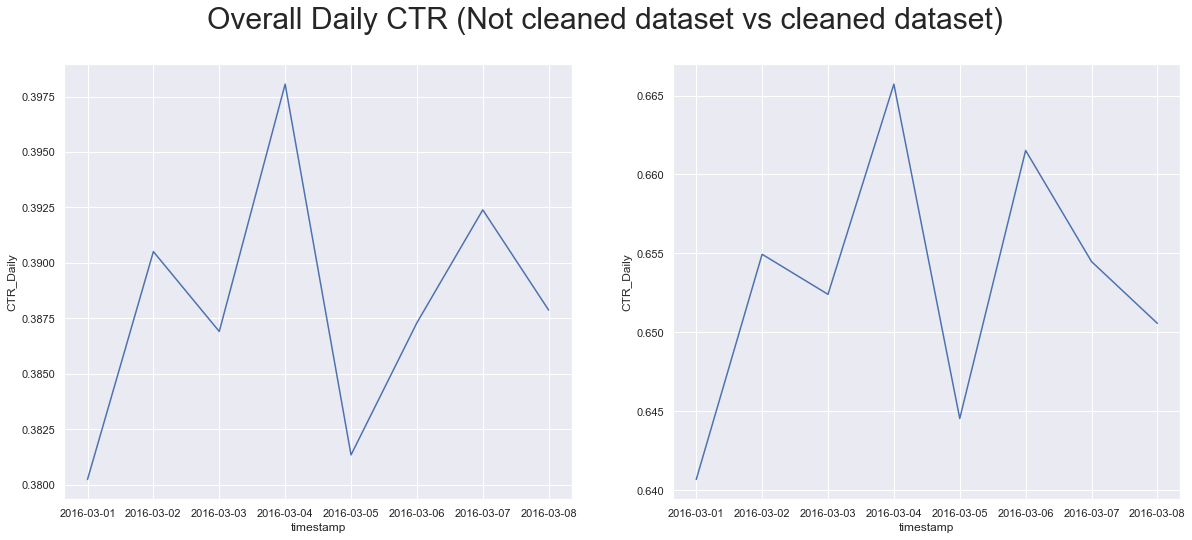

In [1106]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches([20,8])
sns.lineplot(x="timestamp", y="CTR_Daily", data = logs_CTR, ax=ax[0])
sns.lineplot(x="timestamp", y="CTR_Daily", data = logs_cleaned_CTR, ax=ax[1])
fig.suptitle('Overall Daily CTR (Not cleaned dataset vs cleaned dataset)', fontsize= 30)
plt.savefig('logs_insights/Daily_CTR.png', dpi=300)
plt.show()

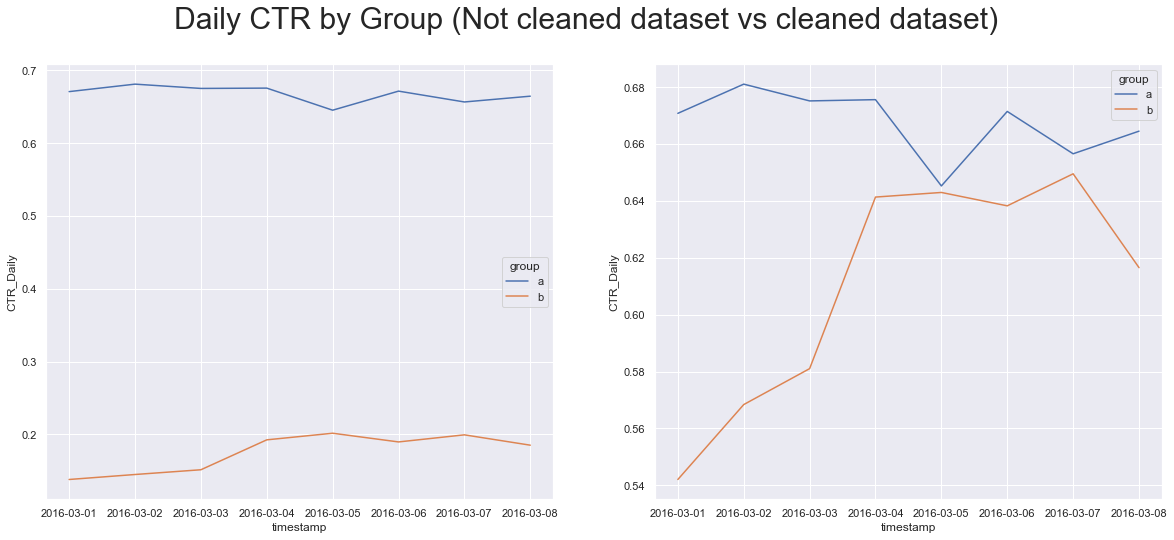

In [1107]:
#Visualizing overall daily overall clickthrough rate
fig, ax =plt.subplots(1,2)
fig.set_size_inches([20,8])
sns.lineplot(x="timestamp", y="CTR_Daily", data = logs_CTR_Group, hue = 'group', linewidth= 1.5, markers=True, ax=ax[0] )
sns.lineplot(x="timestamp", y="CTR_Daily", data = logs_cleaned_CTR_Group, hue = 'group', linewidth= 1.5, markers=True, ax=ax[1])
fig.suptitle('Daily CTR by Group (Not cleaned dataset vs cleaned dataset)', fontsize= 30)
plt.savefig('logs_insights/Daily_CTR_Group.png', dpi=300)
plt.show()

## Task 2: Which results do people tend to try first? How does it change day-to-day?

In [1108]:
#Filtering out by Checking and removing NaN results:
logs_search = logs[(logs['action'] == 'checkin') & (~logs['result_position'].isnull())]
logs_search = logs_search.drop_duplicates(subset = ['session_id'], keep='first')
crosstab = pd.crosstab(logs_search['timestamp'].dt.date, logs_search['result_position'], normalize='index')
crosstab


result_position,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,83.0,90.0,94.0,105.0,121.0,141.0,174.0,185.0,198.0,3895.0
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-03-01,0.662059,0.143055,0.070145,0.032481,0.024879,0.013822,0.011748,0.005183,0.005874,0.005183,...,0.000346,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000346
2016-03-02,0.659337,0.137009,0.076455,0.040257,0.018606,0.016576,0.009811,0.010825,0.006766,0.002030,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2016-03-03,0.658232,0.135393,0.072626,0.033520,0.022018,0.018074,0.013145,0.007230,0.006572,0.006572,...,0.000000,0.000000,0.000000,0.000000,0.000329,0.000000,0.00000,0.000329,0.000000,0.000000
2016-03-04,0.673331,0.136737,0.063906,0.037844,0.023206,0.019636,0.006069,0.006426,0.003570,0.003213,...,0.000000,0.000357,0.000357,0.000357,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2016-03-05,0.659526,0.151322,0.066545,0.037830,0.022334,0.011851,0.010027,0.004102,0.005925,0.007293,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2016-03-06,0.661399,0.131964,0.073094,0.042276,0.022916,0.016989,0.009878,0.007507,0.005136,0.004741,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2016-03-07,0.654743,0.134059,0.071540,0.041369,0.022706,0.016796,0.012753,0.006843,0.003421,0.005910,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000311,0.00000,0.000000,0.000311,0.000000
2016-03-08,0.656181,0.135085,0.063657,0.035529,0.025537,0.023686,0.011473,0.008512,0.006292,0.004811,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000370,0.00037,0.000000,0.000000,0.000000


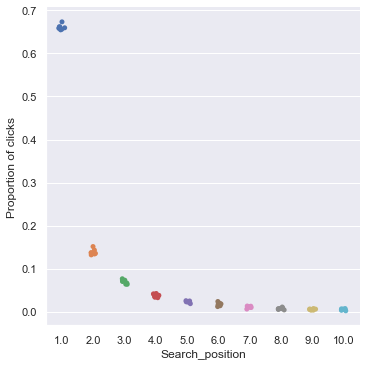

In [1109]:
#Visualizing peoples preference on first 10 results
crosstab_1to10 = crosstab.iloc[:, :10]
crosstab_1to10_melt = pd.melt(crosstab_1to10.reset_index(), id_vars = 'timestamp', var_name="Search_position", value_name = 'Proportion of clicks')

g3 = sns.catplot(data = crosstab_1to10_melt, x = 'Search_position', y= 'Proportion of clicks', ci=None)
plt.savefig('logs_insights/Result_click_preference.png', dpi=300)
plt.show()

## What is our daily overall zero results rate? How does it vary between the groups?

In [1110]:
def ZRR(dataset):
    Total_searches = len(dataset[dataset['action'] == 'searchResultPage'])
    Searches_0_results = len(dataset[(dataset['action'] == 'searchResultPage') & (dataset['n_results'] == 0)])
    x = Searches_0_results / Total_searches
    return x

x_logs_cleaned = ZRR(logs_cleaned)
print(f"Percentage of relevant searches that yielded 0 results: {x_logs_cleaned:.00%}")

x_logs = ZRR(logs)
print(f"Percentage of total searches that yielded 0 results: {x_logs:.00%}")

Percentage of relevant searches that yielded 0 results: 18%
Percentage of total searches that yielded 0 results: 18%


In [1111]:
def overall_zero_result_rate_group(dataset):

    Total_searches = (dataset[dataset['action'] == 'searchResultPage'].groupby([dataset['timestamp'].dt.date, 'group'])['session_id'].agg('count')).reset_index(level= [0,1])
    Searches_0_results = dataset[(dataset['action'] == 'searchResultPage') & (dataset['n_results'] == 0)].groupby([dataset['timestamp'].dt.date, 'group'])['session_id'].agg('count').reset_index(level= [0,1])
    Searches_df = pd.merge(Total_searches, Searches_0_results, left_on=['timestamp','group'], right_on=['timestamp','group']).rename({'session_id_x':'Total_searches', 'session_id_y':'Searches_0_results'},axis=1)
    Searches_df['Proportion_0_Results'] = Searches_df['Searches_0_results']/Searches_df['Total_searches']
    
    return Searches_df


In [1112]:
logs_ZRR = overall_zero_result_rate_group(logs)
logs_cleaned_ZRR = overall_zero_result_rate_group(logs_cleaned)

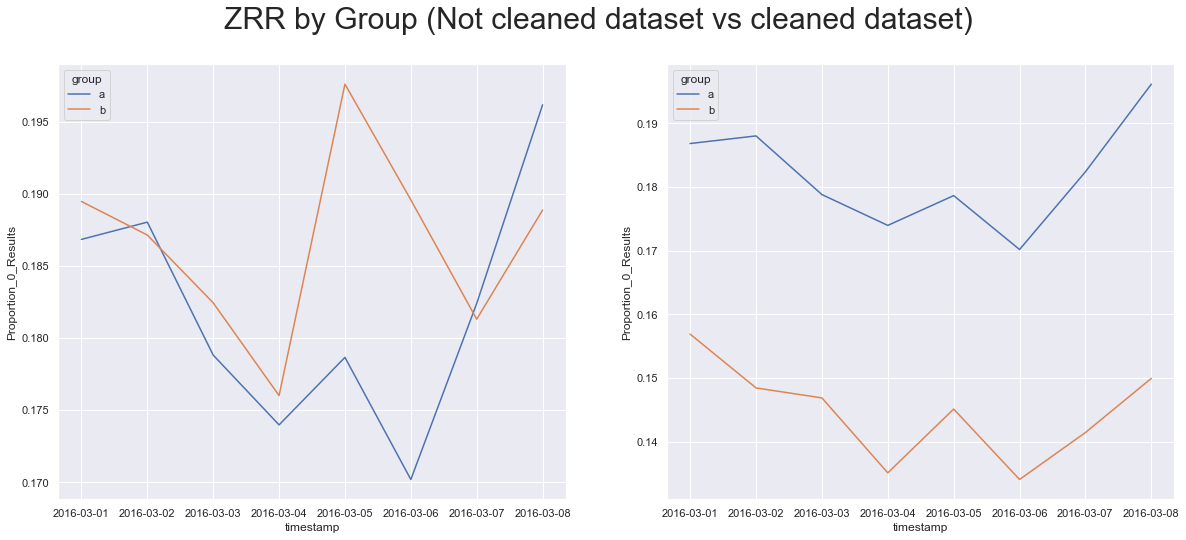

In [1113]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches([20,8])
sns.lineplot(data = logs_ZRR, x = 'timestamp', y = 'Proportion_0_Results', hue = 'group', ax=ax[0])
sns.lineplot(data = logs_cleaned_ZRR, x = 'timestamp', y = 'Proportion_0_Results', hue = 'group', ax=ax[1])
fig.suptitle('ZRR by Group (Not cleaned dataset vs cleaned dataset)', fontsize= 30)
plt.savefig('logs_insights/ZRR_Group.png', dpi=300)
plt.show()

## Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.

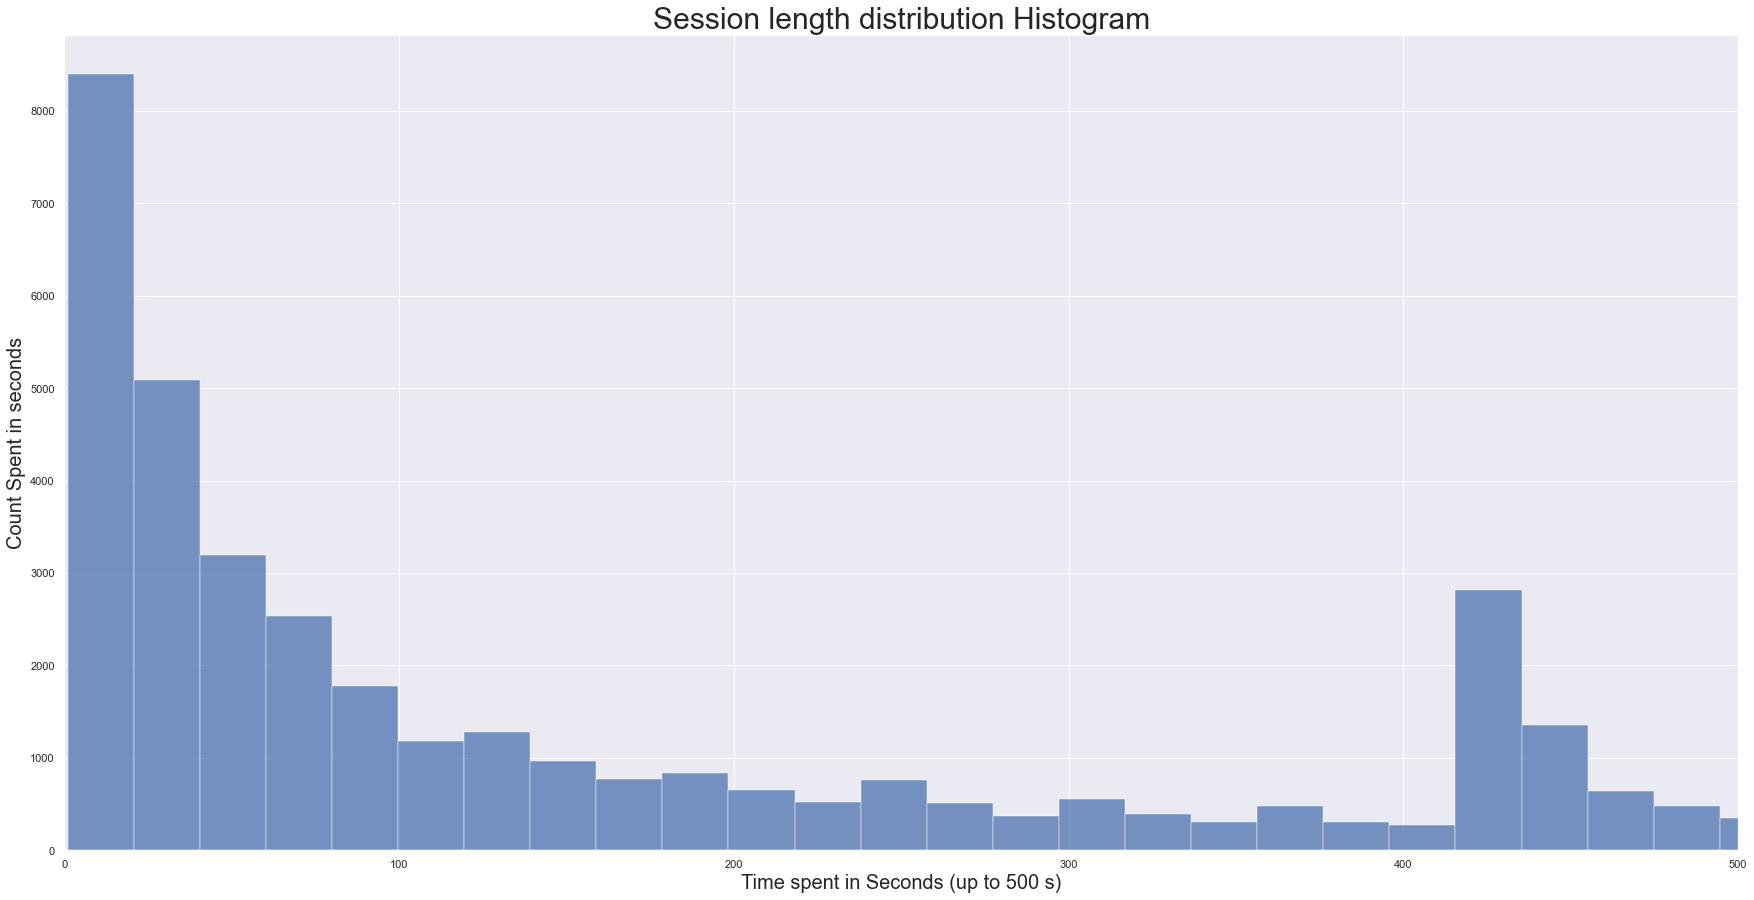

In [1114]:
#Histogram of total session length (without outliers and 0 session length)
group_session_filtered = group_session[(z < 3) & (group_session['max'] != group_session['min'])]
sns.set(rc={'figure.figsize':(30,15)})
g5 = sns.histplot(x= 'time_spent_seconds' ,data = group_session_filtered)
g5.set_title("Session length distribution Histogram", fontsize=30)
g5.set_xlabel("Time spent in Seconds (up to 500 s)",fontsize=20)
g5.set_ylabel("Count Spent in seconds",fontsize=20)
plt.xlim(0, 500)
plt.savefig('logs_insights/Hist_session_length_distribution.png', dpi=300)
plt.show()

In [1115]:
group_session_min = logs.groupby(['session_id', 'group'])['timestamp', 'action'].min().reset_index(level= [0,1])
group_session_max = logs.groupby(['session_id', 'group'])['timestamp', 'action', 'result_position'].max().reset_index(level= [0,1])
group_session_action = pd.merge(group_session_min, group_session_max, left_on = ['session_id', 'group'], right_on = ['session_id', 'group'])
group_session_action.columns = ['session_id', 'group', 'timestamp_min','action_min', 'timestamp_max','action_max', 'result_position']
group_session_action['time_spent'] = (group_session_action['timestamp_max'] - group_session_action['timestamp_min']).astype('timedelta64[s]')

group_session_action.head()

<ipython-input-1115-bddfe002b2dc>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_session_min = logs.groupby(['session_id', 'group'])['timestamp', 'action'].min().reset_index(level= [0,1])
<ipython-input-1115-bddfe002b2dc>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_session_max = logs.groupby(['session_id', 'group'])['timestamp', 'action', 'result_position'].max().reset_index(level= [0,1])


,session_id,group,timestamp_min,action_min,timestamp_max,action_max,result_position,time_spent
0,0000cbcb67c19c45,b,2016-03-03 15:20:45,searchResultPage,2016-03-03 15:20:45,searchResultPage,NaN,0.0
1,0001382e027b2ea4,b,2016-03-07 08:49:55,checkin,2016-03-07 08:54:58,visitPage,1.0,303.0
2,0001e8bb90445cb2,b,2016-03-05 09:24:15,checkin,2016-03-05 09:31:30,visitPage,1.0,435.0
3,000216cf18ae1ab1,a,2016-03-08 16:19:46,searchResultPage,2016-03-08 16:20:44,searchResultPage,NaN,58.0
4,000527f711d50dfc,b,2016-03-08 05:33:00,searchResultPage,2016-03-08 05:33:00,searchResultPage,NaN,0.0


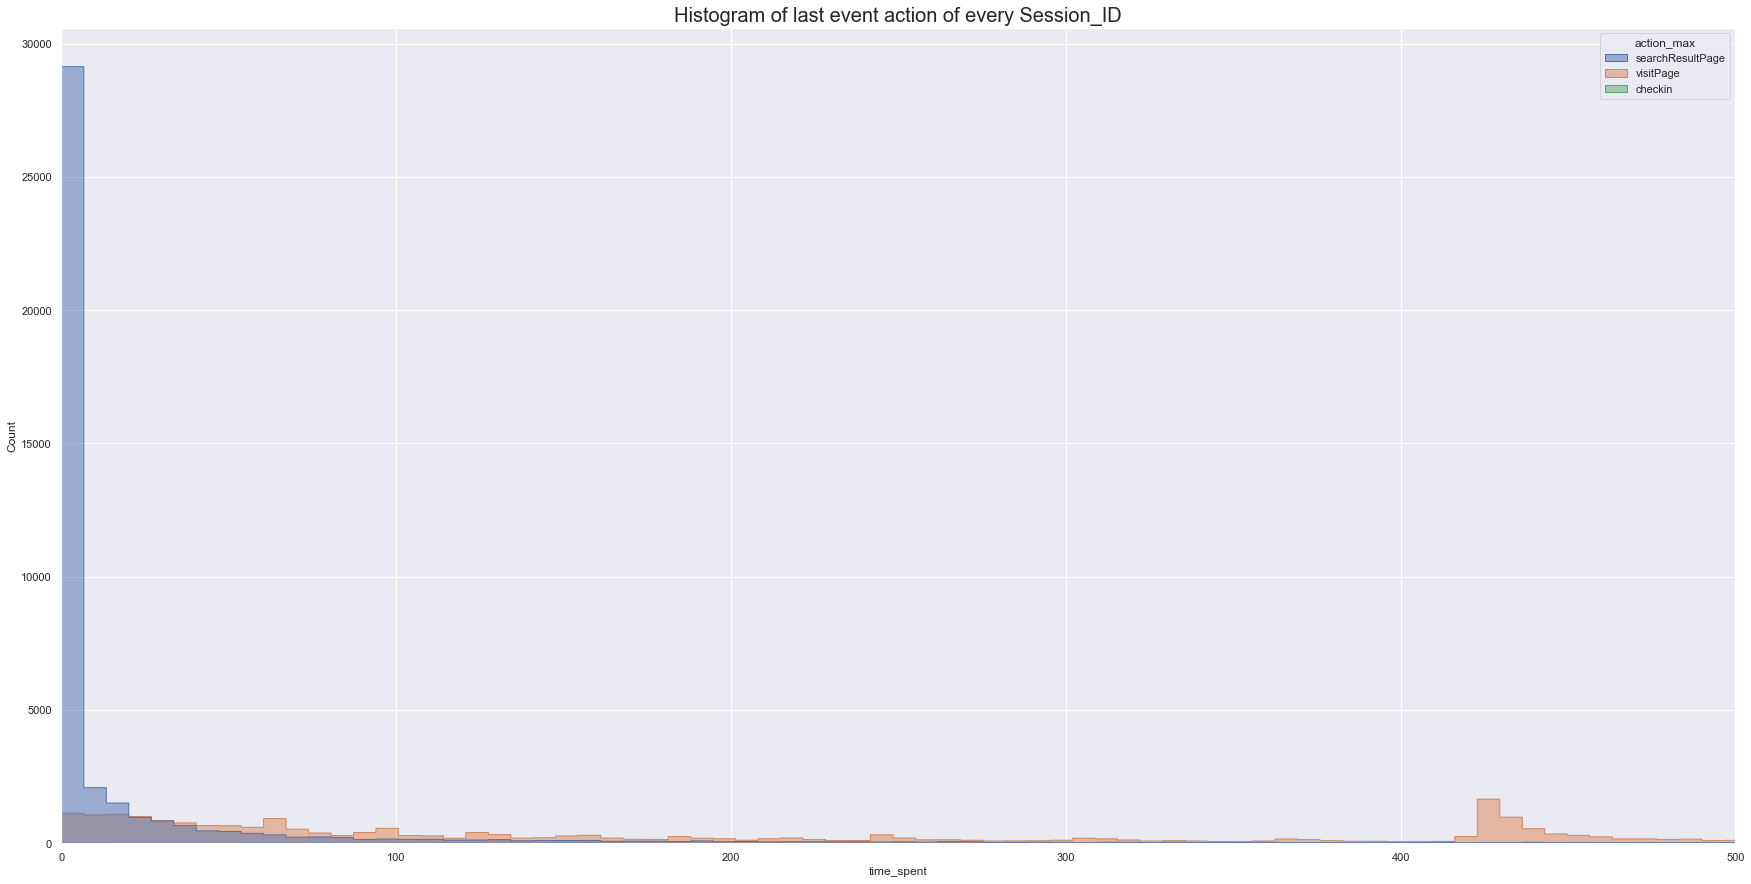

In [1116]:
sns.histplot(data = group_session_action, x = 'time_spent', alpha=0.5, hue = 'action_max', element="step")
plt.xlim(0, 500)
plt.title("Histogram of last event action of every Session_ID", fontsize = 20)
plt.savefig('logs_insights/Hist_Event_Action.png', dpi=300)
plt.show()

In [1117]:
#Obtaining the distribution of time length based on the first 10 result position
visit_page = logs[(logs['action'] == 'visitPage') & (logs['result_position'] > 0) & (logs['result_position'] <= 10)]
visit_page = visit_page[['session_id', 'result_position']].drop_duplicates(subset='session_id', keep=False)
# visit_page
results_to10 = pd.merge(visit_page, group_session_action, how = 'left', on = ['session_id'])


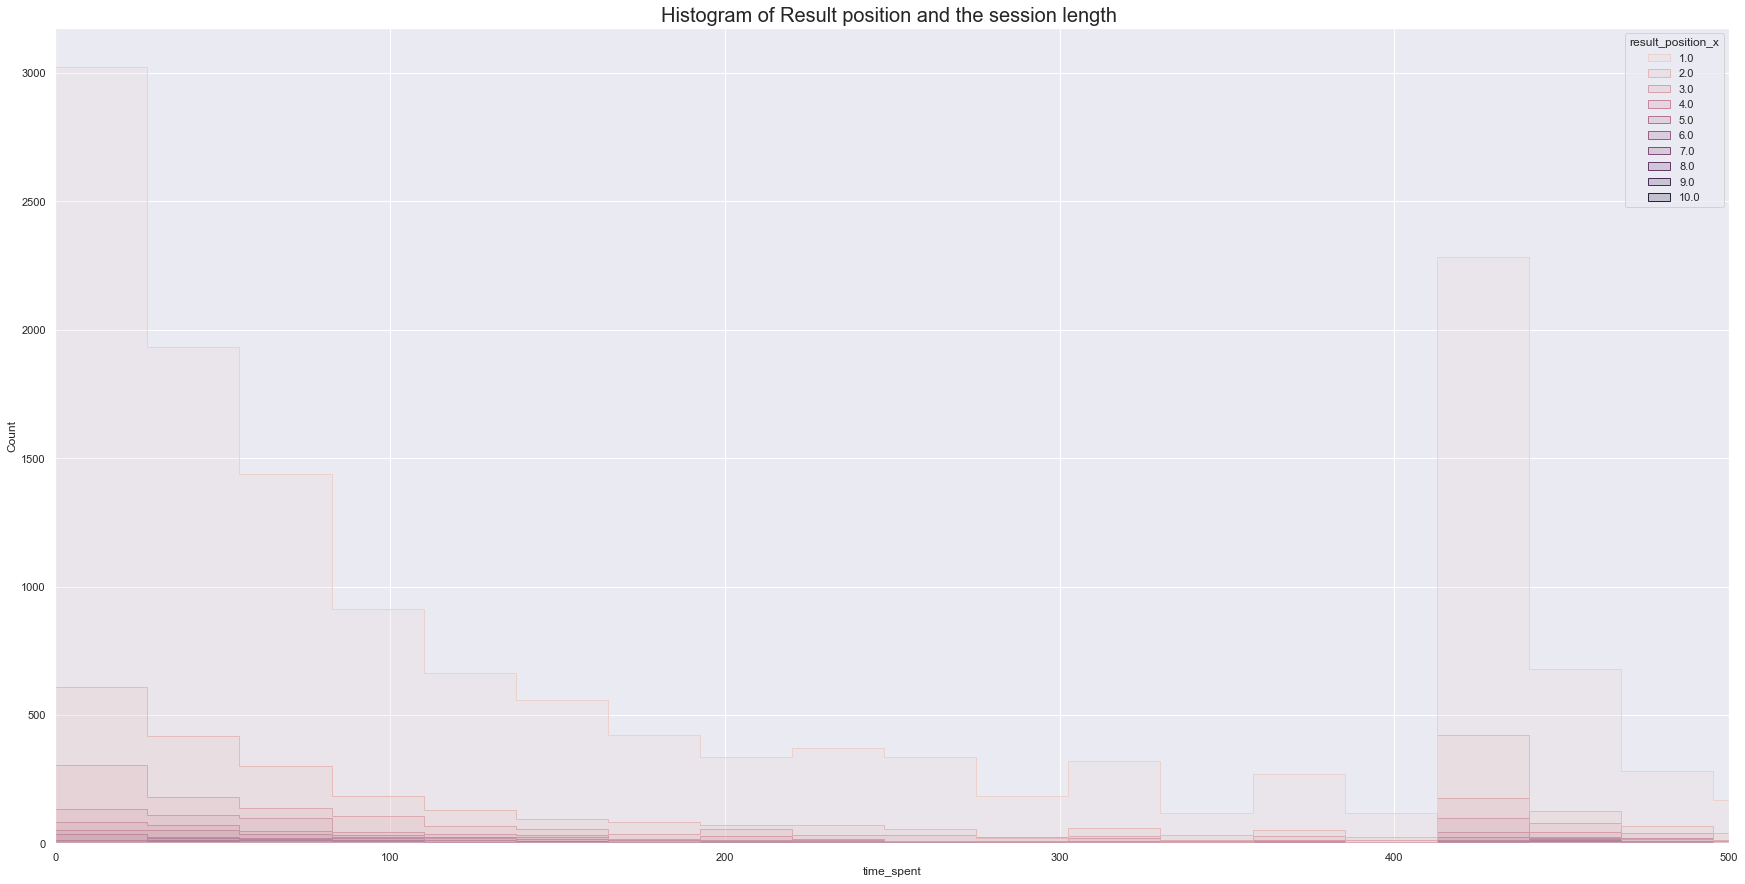

In [1118]:
sns.histplot(data = results_to10, x = 'time_spent', alpha=0.2, hue = 'result_position_x', element="step")
plt.xlim(0, 500)
plt.title("Histogram of Result position and the session length ", fontsize = 20)
plt.savefig('logs_insights/Result_position_Length.png', dpi=300)
plt.show()